# Humor Text Classification with RNN and NLTK

This project uses RNN to classify whether a text is humorous or not. This requires a nuanced understanding of the context of the words in each text because humorous and nonhumorous texts can share similiar vocabulary. For example "Why did the chicken cross the road? To get to the other side" and "Why was there a chicken coop across the road?" share several key words, but we would easily recognize the first as a joke. The combination of natural language processing and RNN will allow a machine learning model to make that same classification.  
RNN is a useful tool for this project because it is well suited to identifying patterns in texts. An RNN is able to retain information. This project will specifically use an LSTM, which retains a long term store of information while making short term modifications.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from wordcloud import WordCloud

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [2]:
# Import data
df = pd.read_csv(r"C:\Users\mmull\OneDrive\Documents\MSDS\Deep learning\FInal project\jokes.csv")

# EDA
The dataset was generated for the purposes of a paper on BERT Sentence Embedding (https://arxiv.org/abs/2004.12765). It consists of 200,000 short texts, which are either humorous or not. The dataset provides the texts and a boolean classification. The distribution between the two classes is equal, so over or under representation is not a concern. There are no missing or duplicate values in the dataset.  
The mean character count of the humorous texts is slightly larger than for the nonhumorous texts (70.0 vs 64.9).
The word clouds and table of ngrams provide some insight into which words or phrases are most common in each class. The common phrases in the humor class include phrases frequently used in jokes (e.g., "Knock, knock" and "chicken cross road").

In [3]:
print(df.shape)
df.head()

(200000, 2)


,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


Text(0.5, 1.0, 'Class Distribution')

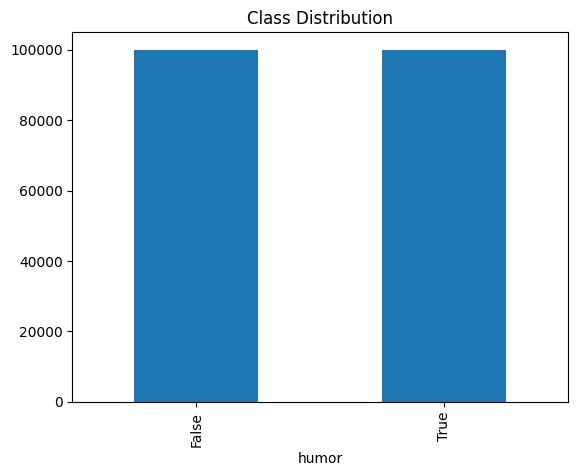

In [4]:
# Class distribution
df.humor.value_counts().plot(kind = 'bar')

plt.title('Class Distribution')

In [5]:
# Check for duplicates and missing values

print('Is Duplicated', df.text.duplicated().sum())
print('Is Null')
print(df.isnull().sum())

Is Duplicated 0
Is Null
text     0
humor    0
dtype: int64


In [6]:
# Sample humorous and nonhumorous texts
humor = df[df.humor == True]
nonhumor = df[df.humor == False]
print(humor.head())
print(nonhumor.head())

                                                 text  humor
2   What do you call a turtle without its shell? d...   True
6   What is a pokemon master's favorite kind of pa...   True
7   Why do native americans hate it when it rains ...   True
9       My family tree is a cactus, we're all pricks.   True
13  How are music and candy similar? we throw away...   True
                                                text  humor
0  Joe biden rules out 2020 bid: 'guys, i'm not r...  False
1  Watch: darvish gave hitter whiplash with slow ...  False
3      5 reasons the 2016 election feels so personal  False
4  Pasco police shot mexican migrant from behind,...  False
5  Martha stewart tweets hideous food photo, twit...  False


In [42]:
# Word count between categories
mean_length_humor = np.mean(humor.text.str.len())
mean_length_nonhumor = np.mean(nonhumor.text.str.len())
print('Mean character count of humorous texts:', round(mean_length_humor, 1))
print('Mean character count of nonhumorous texts:', round(mean_length_nonhumor, 1))

Mean character count of humorous texts: 70.0
Mean character count of nonhumorous texts: 64.9


# Preprocess
In order to preprocess the text, I used NLTK functionalities. This process yields texts that are more easily fed into the LSTM model. The preprocessing steps were:
- Convert text to lowercase
- Tokenize the words
- Remove stop words
- Lemmatize

In [8]:
# Function to preprocess the text
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    text = word_tokenize(text)
    text = [word for word in text if word.casefold() not in set(stopwords.words('english')) and word.isalpha()]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [9]:
# Apply preprocessing
df['clean_text'] = df['text'].apply(lambda txt: preprocess(txt))
df['clean_text'].head()

0                           joe biden rule bid running
1        watch darvish gave hitter whiplash slow pitch
2                       call turtle without shell dead
3                        reason election feel personal
4    pasco police shot mexican migrant behind new a...
Name: clean_text, dtype: object

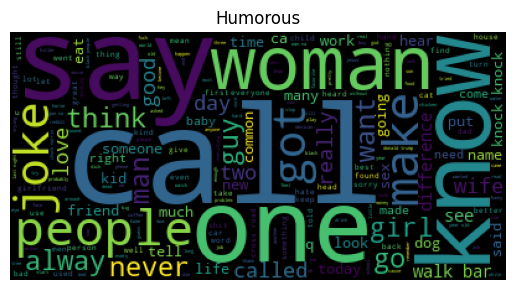

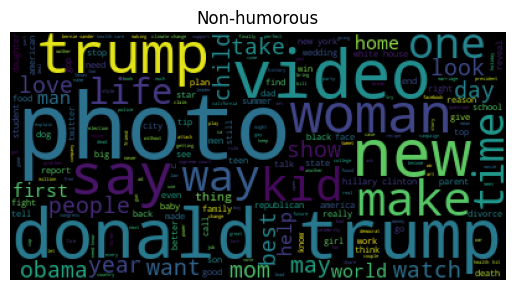

In [10]:
# Word clouds
humor = df[df.humor == True]
nonhumor = df[df.humor == False]

tcloud = WordCloud().generate(' '.join(humor['clean_text'].values))
plt.axis('off')
plt.title('Humorous')
plt.imshow(tcloud)
plt.show()

fcloud = WordCloud().generate(' '.join(nonhumor['clean_text'].values))
plt.axis('off')
plt.title('Non-humorous')
plt.imshow(fcloud)

In [11]:
# Frequency distributions
# Create corpus
def corpus(df):
    corpus = []
    for tweet in df:
        for tweet in df['clean_text']:
            tweet = word_tokenize(tweet)
            for word in tweet:
                corpus.append(word)
    return corpus
true_corpus = corpus(humor)
false_corpus = corpus(nonhumor)

In [12]:
# Function to remove common words between two sets
def delete_common(corpus1, corpus2):
    common_words = set(corpus1).intersection(corpus2)
    for word in common_words:
        del corpus1[word]
        del corpus2[word]
        
# Single words
humor_fd = nltk.FreqDist(true_corpus)
nonhumor_fd = nltk.FreqDist(false_corpus)

delete_common(humor_fd, nonhumor_fd)

# Bigrams
humor_bigrams = nltk.collocations.BigramCollocationFinder.from_words([word for word in true_corpus])
nonhumor_bigrams = nltk.collocations.BigramCollocationFinder.from_words([word for word in false_corpus])

delete_common(humor_bigrams.ngram_fd, nonhumor_bigrams.ngram_fd)

# Trigrams
humor_trigrams = nltk.collocations.TrigramCollocationFinder.from_words([word for word in true_corpus])
nonhumor_trigrams = nltk.collocations.TrigramCollocationFinder.from_words([word for word in false_corpus])

delete_common(humor_trigrams.ngram_fd, nonhumor_trigrams.ngram_fd)

# Table of humor ngrams
ngram_df = pd.DataFrame({'1': humor_fd.most_common(20), 
                         '2': humor_bigrams.ngram_fd.most_common(20), 
                         '3': humor_trigrams.ngram_fd.most_common(20)})
ngram_df

,1,2,3
0,"(fuck, 1761)","((knock, knock), 2478)","((like, woman, like), 1053)"
1,"(fucking, 1608)","((get, cross), 1101)","((woman, like, like), 774)"
2,"(whats, 1524)","((like, coffee), 960)","((take, change, lightbulb), 480)"
3,"(favourite, 1116)","((take, change), 864)","((man, walk, bar), 465)"
4,"(lightbulb, 1032)","((yo, mama), 801)","((chicken, cross, road), 447)"
5,"(midget, 951)","((call, mexican), 573)","((like, coffee, like), 408)"
6,"(dyslexic, 606)","((black, guy), 570)","((wan, na, hear), 387)"
7,"(im, 561)","((take, screw), 567)","((like, like, coffee), 372)"
8,"(cunt, 453)","((chicken, cross), 543)","((change, light, bulb), 351)"
9,"(cant, 420)","((change, lightbulb), 513)","((yo, mama, fat), 345)"


In [35]:
# Table of nonhumor ngrams
nonngram_df = pd.DataFrame({'1': nonhumor_fd.most_common(20), 
                         '2': nonhumor_bigrams.ngram_fd.most_common(20), 
                         '3': nonhumor_trigrams.ngram_fd.most_common(20)})
nonngram_df

,1,2,3
0,"(huffpost, 1239)","((morning, email), 777)","((huffpost, rise, need), 354)"
1,"(reportedly, 900)","((jimmy, fallon), 531)","((rise, need, know), 354)"
2,"(allegedly, 666)","((bill, maher), 468)","((new, york, fashion), 303)"
3,"(amid, 633)","((photo, poll), 444)","((york, fashion, week), 303)"
4,"(fallon, 564)","((week, photo), 432)","((photo, donald, trump), 240)"
5,"(defends, 555)","((pope, francis), 429)","((woman, business, q), 222)"
6,"(debut, 552)","((kate, middleton), 396)","((wednesday, morning, email), 174)"
7,"(middleton, 531)","((gps, guide), 393)","((tuesday, morning, email), 165)"
8,"(warns, 528)","((chrissy, teigen), 381)","((friday, morning, email), 162)"
9,"(huffpollster, 495)","((roy, moore), 378)","((everything, need, know), 159)"


# Tokenization and Word Embedding
I used the Keras preprocessing module to finish preparing the text for embedding. The tokenized texts were converted to sequences, which were padded in order to ensure they were of equal lengths.  
Word embedding allows for the representation of words as vectors of numbers. I am using a pretrained Word2Vec, which is a prediction-based embedding. Prediction-based embeddings result in words that are semantically similar being close together. Word2Vec uses both continuous bag of words and continuous skip-gram models to either predict a word based on its context or the context based on a given word.

In [13]:
# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(df.clean_text, df.humor, test_size = 0.2, random_state = 42)

In [14]:
# Tokenize
vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(x_train)
X_test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad sequences to make them of equal lengths
max_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen = max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_length, padding='post')

In [15]:
# Word2vec
word2vec = api.load('word2vec-google-news-300')

embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
     if word in word2vec:
        embedding_matrix[i] = word2vec[word]

# Models
An LSTM maintains a long term memory store while using several gates to modify what information is added to or removed from the memory store.
- Forget: determine information removed
- Input: determine information added
- Update: execute the forgetting and inputting
- Output: prepares the information to be based along.  
A bidirectional LSTM uses two LSTM layers. One forward processes information and the other backward processes information. This allows for better learning of sequences. Overfitting can occur with BiLSTM, so several architectures will be evaluated. This project will compare 3 BiLSTM architectures:
- A BiLSTM layer
- A BiLSTM layer and a dropout layer
- A BiLSTM layer with L2 regularization

In [16]:
# simple BiLSTM
model_bilstm_s = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 64),
    Bidirectional(LSTM(128)),
    Dense(1, activation = 'sigmoid')
])

model_bilstm_s.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_bilstm_s.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# BiLSTM with dropout
model_bilstm = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 64),
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model_bilstm.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_bilstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# BiLSTM with regularization
model_bilstm_m = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 64),
    Bidirectional(LSTM(128, kernel_regularizer = tf.keras.regularizers.L2(0.005))),
    Dense(1, activation = 'sigmoid')
])

model_bilstm_m.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_bilstm_m.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training
Prior to training, I split the training dataset into a training and validation set to monitor overfitting. Each model used a binary crossentropy loss and ADAM optimizer. The accuracy and loss are plotted below and the accuracy on the test dataset is calculated.

In [19]:
# Training and val sets
x_train, x_val, y_train, y_val = train_test_split(X_train_padded, y_train, test_size = 0.2, random_state = 42)

In [33]:
# Plotting functions

def plot(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label = 'Train')
    plt.plot(history.history['val_accuracy'], label = 'Val')
    plt.title(model_name + ' Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label = 'Train')
    plt.plot(history.history['val_loss'], label = 'Val')
    plt.title(model_name + ' Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [20]:
# Simple model
history_bilstm_s = model_bilstm_s.fit(x_train, y_train, epochs = 5, batch_size = 64, validation_data = (x_val, y_val))

Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 316s 156ms/step - accuracy: 0.8214 - loss: 0.3721 - val_accuracy: 0.9007 - val_loss: 0.2356
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 318s 159ms/step - accuracy: 0.9193 - loss: 0.1983 - val_accuracy: 0.9017 - val_loss: 0.2402
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 321s 161ms/step - accuracy: 0.9347 - loss: 0.1635 - val_accuracy: 0.9033 - val_loss: 0.2315
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 325s 163ms/step - accuracy: 0.9454 - loss: 0.1376 - val_accuracy: 0.8994 - val_loss: 0.2546
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 383s 163ms/step - accuracy: 0.9561 - loss: 0.1101 - val_accuracy: 0.8976 - val_loss: 0.2905


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.8976 - loss: 0.2900
Simple Bidirectional LSTM Validation Accuracy:  0.8987500071525574


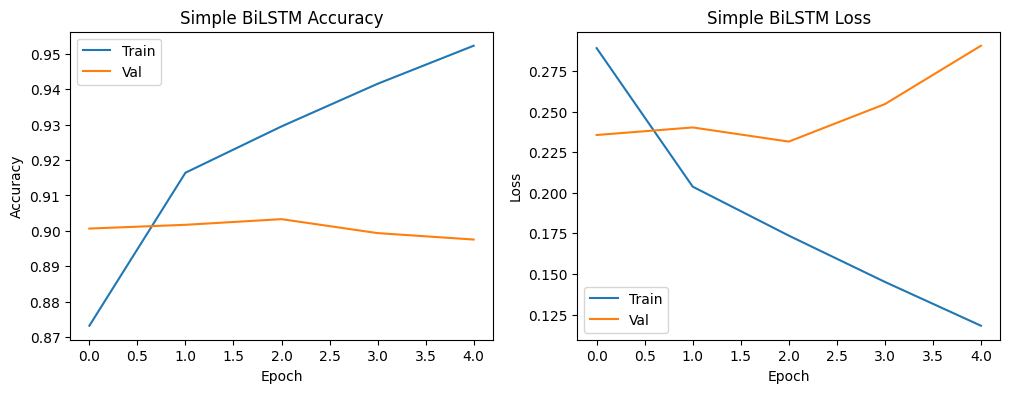

In [24]:
val_loss_bilstm_s, val_acc_bilstm_s = model_bilstm_s.evaluate(X_test_padded, y_test)

plot(history_bilstm_s, 'Simple BiLSTM')

print('BiLSTM Validation Accuracy: ', val_acc_bilstm_s)

In [21]:
# BiLSTM with dropout
history_bilstm = model_bilstm.fit(x_train, y_train, epochs = 5, batch_size = 64, validation_data = (x_val, y_val))

Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 318s 157ms/step - accuracy: 0.8189 - loss: 0.3911 - val_accuracy: 0.8938 - val_loss: 0.2487
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 311s 155ms/step - accuracy: 0.9128 - loss: 0.2128 - val_accuracy: 0.9025 - val_loss: 0.2342
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 314s 157ms/step - accuracy: 0.9275 - loss: 0.1761 - val_accuracy: 0.9022 - val_loss: 0.2398
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 317s 159ms/step - accuracy: 0.9398 - loss: 0.1486 - val_accuracy: 0.9023 - val_loss: 0.2506
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 321s 160ms/step - accuracy: 0.9503 - loss: 0.1221 - val_accuracy: 0.8995 - val_loss: 0.2894


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.8981 - loss: 0.2930
Bidirectional LSTM Validation Accuracy:  0.9008499979972839


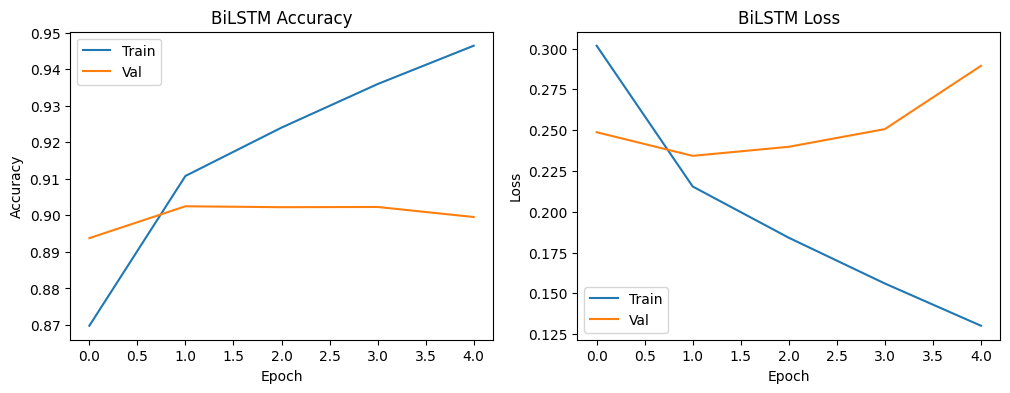

In [25]:
plot(history_bilstm, 'BiLSTM')


In [28]:
# BiLSTM with regularization
history_bilstm_m = model_bilstm_m.fit(x_train, y_train, epochs = 5, batch_size = 64, validation_data = (x_val, y_val))

Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 307s 151ms/step - accuracy: 0.8085 - loss: 0.5594 - val_accuracy: 0.8928 - val_loss: 0.2691
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 306s 153ms/step - accuracy: 0.9060 - loss: 0.2437 - val_accuracy: 0.8886 - val_loss: 0.2681
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 303s 152ms/step - accuracy: 0.9201 - loss: 0.2075 - val_accuracy: 0.9008 - val_loss: 0.2440
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 320s 160ms/step - accuracy: 0.9274 - loss: 0.1892 - val_accuracy: 0.9020 - val_loss: 0.2409
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 352s 176ms/step - accuracy: 0.9320 - loss: 0.1758 - val_accuracy: 0.8980 - val_loss: 0.2502


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.8992 - loss: 0.2478
Multiple Bidirectional LSTM Validation Accuracy:  0.9010249972343445


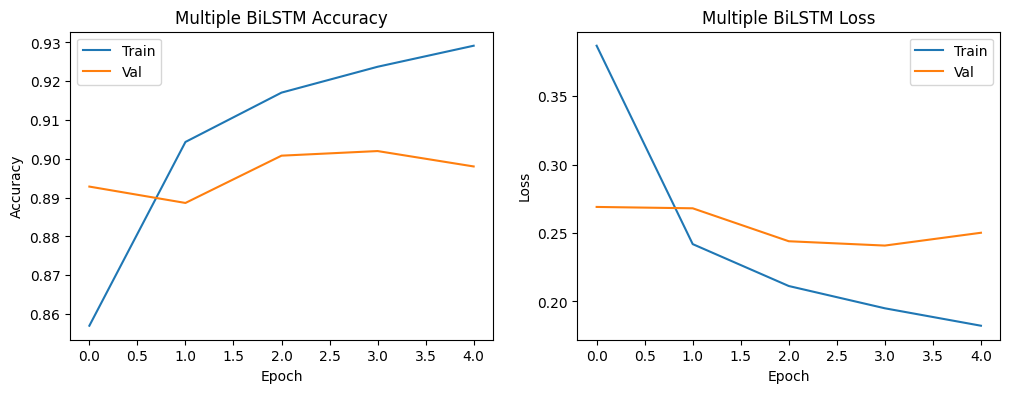

In [29]:
plot(history_bilstm_m, 'Multiple BiLSTM')


# Hypertuning

Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 520s 258ms/step - accuracy: 0.8045 - loss: 1.3050 - val_accuracy: 0.8922 - val_loss: 0.2789
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 509s 254ms/step - accuracy: 0.9033 - loss: 0.2540 - val_accuracy: 0.8945 - val_loss: 0.2581
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 517s 258ms/step - accuracy: 0.9136 - loss: 0.2221 - val_accuracy: 0.8993 - val_loss: 0.2492
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 563s 259ms/step - accuracy: 0.9228 - loss: 0.1992 - val_accuracy: 0.8995 - val_loss: 0.2447
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 483s 241ms/step - accuracy: 0.9276 - loss: 0.1888 - val_accuracy: 0.9002 - val_loss: 0.2461


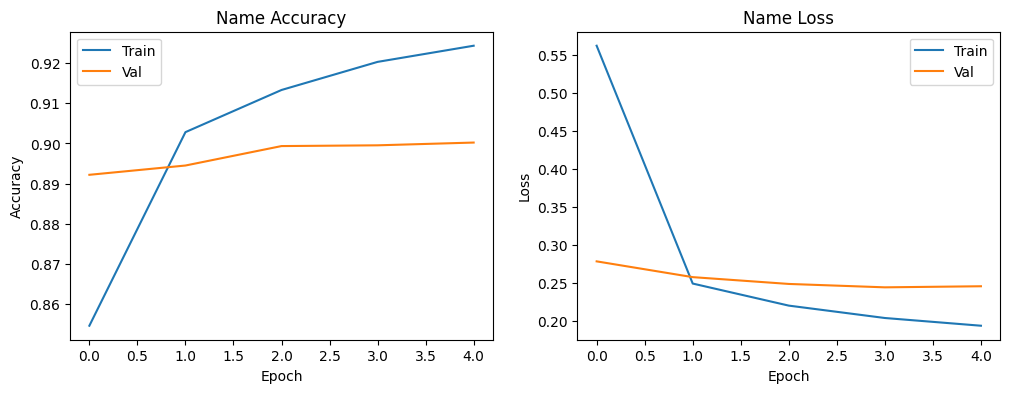

Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 424s 210ms/step - accuracy: 0.8033 - loss: 2.0591 - val_accuracy: 0.8909 - val_loss: 0.2841
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 409s 205ms/step - accuracy: 0.9042 - loss: 0.2533 - val_accuracy: 0.8989 - val_loss: 0.2520
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 420s 210ms/step - accuracy: 0.9174 - loss: 0.2188 - val_accuracy: 0.8982 - val_loss: 0.2520
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 431s 216ms/step - accuracy: 0.9227 - loss: 0.2013 - val_accuracy: 0.8965 - val_loss: 0.2558
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 530s 265ms/step - accuracy: 0.9255 - loss: 0.1936 - val_accuracy: 0.8971 - val_loss: 0.2527


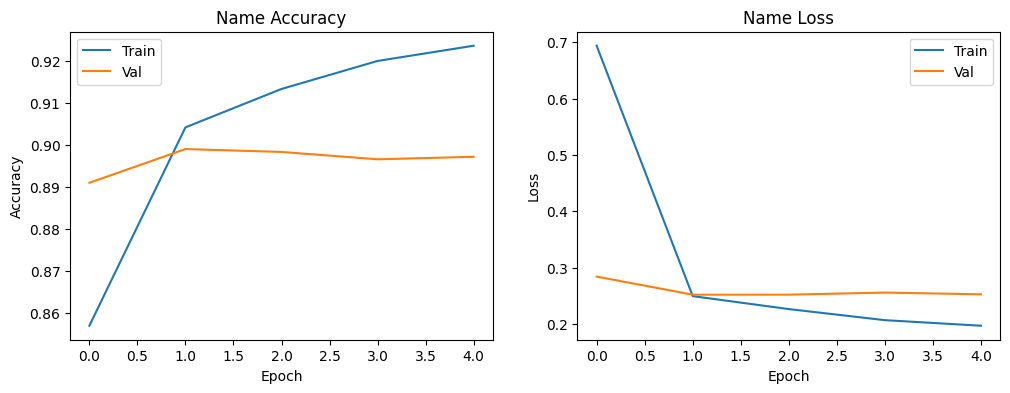

In [34]:
for val in [0.005, 0.01, 0.05, 0.1]:
    model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 64),
    Bidirectional(LSTM(128, kernel_regularizer = tf.keras.regularizers.L2(val))),
    Dense(1, activation = 'sigmoid')
])

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    history = model.fit(x_train, y_train, epochs = 5, batch_size = 64, validation_data = (x_val, y_val), verbose = False)
    plot(history, f'Factor = {val}')

In [46]:
# Accuracy of final model on test dataset
loss_bilstm_m, acc_bilstm_m = model.evaluate(X_test_padded, y_test)
print('Regularized BiLSTM Test Accuracy: ', round(acc_bilstm_m,2))

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.8967 - loss: 0.2552
Regularized BiLSTM Test Accuracy:  0.8978750109672546


# Results
## Architecture
The three architectures consisted of:
- A bidirectional LSTM layer
- A bidirectional LSTM layer with a dropout layer
- A bidirectional LSTM layer with L2 regularization  
These architectures achieved similar accuracies for the test data; however, they showed varying degrees of overfitting to the training data. Looking at the loss function plots, the two architectures without regularization show the validation loss beginning to increase after the 2nd epoch while the training loss continues to decrease. Similarly, the training accuracy increases as the validation accuracy flattens out. When regularization is added, the training and validation data follow a more similar pattern. For this reason, I selected the architecture with regularization.
## Hypertuning
Hypertuning focused on the regularization factor. 0.005, 0.01, 0.05, 0.1 were selected as candidate factors. As the regularization factor increases, the discrepency between the training and validation accuracy and loss decreases.
## Final Model
The final model consists of a bidirectional LSTM layer with an L2 regularization factor of 0.1. On the test set, it achieved an accuracy of 0.9 and a loss of 0.3.

# Conclusion
The BiLSTM with regularization was the most successful model. It achieved accurate classifcation while reducing the overfitting observed in other models. Increasing the regularization factor further reduced overfitting.
## Future directions
The texts used in this project were short. It is likely easier to identify the pattern of a joke contained in a brief text. It would be interesting to explore applying these strategies to longer texts, which may use several sentences to establish the joke.

Data source: https://github.com/Moradnejad/ColBERT-Using-BERT-Sentence-Embedding-for-Humor-Detection/tree/master?tab=readme-ov-file
- https://towardsdatascience.com/simple-word-embedding-for-natural-language-processing-5484eeb05c06
- https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/
- https://www.ibm.com/topics/word-embeddings